# LLM Fine-Tuning

This is a companion notebook to the SIH seminar LLM Fine-tuning.
In this example we will use OpenAI's finetuning API and start with the base model GPT-3.5.
The notebook will demonstrate on two examples the following finetuning processes:
- prepare dataset for finetuning
- validate dataset and estimate tokens and cost
- submit finetuning model for training
- evaluate model
- use model and integrate in workflow

Author: Sebastian Haan

## Installation 

Recommend to setup a new python environment (e.g. with conda).
Install following packages if not installed yet:

In [115]:
!pip install timm tiktoken tabulate ipython matplotlib pandas numpy openai

### Import dependencies

In [1]:
# Add package libraries in folder tools
import sys
import os
import openai
import torch
import json
import tiktoken
import requests
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

## OpenAI Authentication

Authentication with your OpenAI API key for GPT usage (base model here: GPT-3.5-turbo).
Note that this will incur charges on your OpenAI account.

In [2]:
# Note: Authentication changed with new openai version
# Authentication can be done by setting the environment variable OPENAI_API_KEY 
# or via the api_key parameter in the constructor:
from openai import OpenAI

with open(os.path.expanduser("../../openai_sih_key.txt")) as f:
    openai.api_key = f.read().strip()

client = OpenAI(api_key = openai.api_key)

### Test Query

In [3]:
def query_gpt(query, model, system_str = "You are a helpful assistant.", temperature =0, max_tokens=1000):
  response = client.chat.completions.create(
    model=model,
    messages=[
      {"role": "system", "content": system_str},
      {"role": "user", "content": query},
    ],
    temperature=temperature,
    max_tokens=max_tokens,
  )
  return response.choices[0].message.content

In [4]:
query = "What is your training date cut-off?"
result = query_gpt(query, model = "gpt-3.5-turbo")
display(Markdown(result))

As an AI language model, I don't have a specific training date cut-off. My training data includes a wide range of information from various sources up until September 2021. However, please note that I may not have access to real-time information or recent events beyond my training date.

In [6]:
# Let's ask about some info about new APIs such as GPT Vision
query = "Tell me more about OpenAI's GPT-4 Vision API. If you don't know, just say you don't know."
result = query_gpt(query, model = "gpt-3.5-turbo")
display(Markdown(result))

As of my last update in October 2021, OpenAI has not released any specific information about a GPT-4 Vision API. Therefore, I don't have any details about it at the moment. It's always a good idea to check OpenAI's official website or blog for the latest updates on their products and APIs.

## New data preparation for fine-tuning

### Example I: Build code assistant OpenAI Vision API

As use-case, assume we want a fine-tuned GPT coding assistant for OpenAI Vision.
To get started, we first need to create a suitable training dataset, following the steps:


### 1. Collect Material

Get high quality data and information for your topic:
For GPT-4 Vision the following webpages have API and demonstration sample:
- https://platform.openai.com/docs/guides/vision
- https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding
- https://blog.roboflow.com/gpt-4-image-classification

### 2. Select and Chunk Material into relevant content and code snippets

see 7 files in GPT-Vision_training_raw_material.zip

Ideally you want to improve the splitting of these text and code chunks. 

### 3 Get familiar with training data file-format for finetuning

Here we use OpenAi's finetuning API, which requires the following format for training:

```python
{"messages": [{"role": "system", "content": "You are a helpful Python coding assistant for OpenAI GPT-4 Vision."}, {"role": "user", "content": "What is GPT-4 with Vision?"}, {"role": "assistant", "content": "GPT-4 with Vision, also referred to as GPT-4V or gpt-4-vision-preview, is an adaptation of the model to accept images and answer questions about them."}]}

{"messages": [{"role": "system", "content": "You are a helpful Python coding assistant for OpenAI GPT-4 Vision."}, {"role": "user", "content": "How can I make images available to the model?"}, {"role": "assistant", "content": "You can either pass a link to the image or the base64 encoded image directly in the request."}]}

{"messages": [{"role": "system", "content": "You are a helpful Python coding assistant for OpenAI GPT-4 Vision."}, {"role": "user", "content": "How do I use GPT-4 to analyze images?"}, {"role": "assistant", "content": "To analyze images using GPT-4, you can use the `gpt-4-vision-preview` model. Here's an example code snippet:\n```Python\nfrom openai import OpenAI\n\nclient = OpenAI()\n\nresponse = client.chat.completions.create(\n  model=\"gpt-4-vision-preview\",\n  messages=[\n    {\n      \"role\": \"user\",\n      \"content\": [\n        {\"type\": \"text\", \"text\": \"What\u2019s in this image?\"},\n        {\n          \"type\": \"image_url\",\n          \"image_url\": {\n            \"url\": \"https://link_to_your_image.jpg\",\n          },\n        },\n      ],\n    }\n  ],\n  max_tokens=300,\n)\n\nprint(response.choices[0])\n```"}]}
```

### 3. Generate Question and Answer pairs for each chunk

Trick: Use LLM model to automate question generation given the training material and formatting instructions.

Generate for each chunk 5-10 question - answer pairs (as above)

### 4. Clean generated data

### 4. Split in train and test data

see final files:
- vision_trainset.json
- vision_testset.json

## Data Loading and Validation

In [7]:
fname_train = "../data/vision_trainset.json"
fname_val = "../data/vision_testset.json"

# Load the train dataset
with open(fname_train, 'r', encoding='utf-8') as f:
    lines = f.readlines()
dataset_train = [json.loads(line) for line in lines]

# Load the val dataset
with open(fname_val, 'r', encoding='utf-8') as f:
    lines = f.readlines()
dataset_val = [json.loads(line) for line in lines]

In [8]:
# Initial dataset stats
print("Num examples:", len(dataset_train))
print("First example:")
for message in dataset_train[0]["messages"]:
    print(message)

Num examples: 69
First example:
{'role': 'system', 'content': 'You are a helpful Python coding assistant for OpenAI GPT-4 Vision.'}
{'role': 'user', 'content': "What should I do if I want to send images for processing but don't have a specific question?"}
{'role': 'assistant', 'content': 'You can provide general instructions or a request for analysis without a specific question. Here\'s an example with base64 images:\n```python\nresponse = client.chat.completions.create(\n  model="gpt-4-vision-preview",\n  messages=[\n    {\n      "role": "user",\n      "content": [\n        {\n          "type": "text",\n          "text": "Please analyze these images and provide insights.",\n        },\n        {\n          "type": "base64",\n          "base64": "your_base64_encoded_image_1",\n        },\n        {\n          "type": "base64",\n          "base64": "your_base64_encoded_image_2",\n        },\n      ],\n    }\n  ]\n  # ... additional parameters ...\n)\nprint(response.choices[0])\n```\nYou

### Data validation and token/cost estimates

In [10]:
# validation
from collections import defaultdict
import tiktoken
import numpy as np
def validate_dataset(dataset):
    format_errors = defaultdict(int)

    for ex in dataset:
        if not isinstance(ex, dict):
            format_errors["data_type"] += 1
            continue
            
        messages = ex.get("messages", None)
        if not messages:
            format_errors["missing_messages_list"] += 1
            continue
            
        for message in messages:
            if "role" not in message or "content" not in message:
                format_errors["message_missing_key"] += 1
            
            if any(k not in ("role", "content", "name", "function_call") for k in message):
                format_errors["message_unrecognized_key"] += 1
            
            if message.get("role", None) not in ("system", "user", "assistant", "function"):
                format_errors["unrecognized_role"] += 1
                
            content = message.get("content", None)
            function_call = message.get("function_call", None)
            
            if (not content and not function_call) or not isinstance(content, str):
                format_errors["missing_content"] += 1
        
        if not any(message.get("role", None) == "assistant" for message in messages):
            format_errors["example_missing_assistant_message"] += 1

    if format_errors:
        print("Found errors:")
        for k, v in format_errors.items():
            print(f"{k}: {v}")
    else:
        print("No errors found")


def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1, encoding_name = "cl100k_base"):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages, encoding_name = "cl100k_base"):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [11]:
validate_dataset(dataset_train)

No errors found


In [12]:
validate_dataset(dataset_val)

No errors found


In [13]:
# Check token limits    
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []
encoding = tiktoken.get_encoding("cl100k_base")

for ex in dataset_train:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 58, 299
mean / median: 121.6086956521739, 95.0
p5 / p95: 67.6, 199.8

#### Distribution of num_assistant_tokens_per_example:
min / max: 16, 249
mean / median: 77.42028985507247, 51.0
p5 / p95: 23.8, 156.60000000000002

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


### Cost Estimation

In [15]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

n_epochs = 3
cost_per_token = 0.008/1000 # For GPT-3.5-turbo

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
cost = cost_per_token * n_epochs * n_billing_tokens_in_dataset
print(f'Estimated cost for training is {round(cost,2)} USD.')

Dataset has ~8391 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~25173 tokens
Estimated cost for training is 0.2 USD.


## Fine-Tune model

In [16]:
# Upload Training file for processing

response_train = client.files.create(
  file=open(fname_train, "rb"),
  purpose="fine-tune"
)
train_id = response_train.id

In [17]:
response_val = client.files.create(
  file=open(fname_val, "rb"),
  purpose="fine-tune"
)
val_id = response_val.id

In [18]:
# Create a fine-tuned mode
job = client.fine_tuning.jobs.create(
  training_file=train_id, 
  validation_file=val_id,
  model="gpt-3.5-turbo",
  hyperparameters={"n_epochs": 3}
)
job_id = job.id
print(job)


FineTuningJob(id='ftjob-BI9nh1OkLNSf0cHms94mFgQO', created_at=1700372433, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=3, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-vy6zLxkP3VBC5Lnu2GMLswhj', result_files=[], status='validating_files', trained_tokens=None, training_file='file-jTx8o8YLDnckv0zbioUkS3Z5', validation_file='file-pVQqHF0WS6TLHt19cbasuBhH')


In [ ]:
# if job needs to be cancelled:
#client.fine_tuning.jobs.cancel(job_id)

In [22]:
# Check status. Note: you will also receive email notification when the job is done
status = client.fine_tuning.jobs.retrieve(job_id)
if status.status == "succeeded":
    print("Model is ready for use!")
    model_id = status.id
    model_runtime = status.finished_at - status.created_at
    model_trained_tokens = status.trained_tokens
    model_hyperparams = status.hyperparameters
    model_name = status.fine_tuned_model
    model_result_files = status.result_files
    print(f"Model name: {model_name}")
    print(f"Model runtime: {model_runtime} seconds")
    print(f"Model trained tokens: {model_trained_tokens}")
    print(f"Model hyperparameters: {model_hyperparams}")
    print(f"Model result files: {model_result_files}")
elif status.status == "running":
    print("Model is not ready yet, try again later")
else:
    print('status:', status.status)

Model is ready for use!
Model name: ft:gpt-3.5-turbo-0613:sydney-informatics-hub::8MUvoEi0
Model runtime: 374 seconds
Model trained tokens: 24759
Model hyperparameters: Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2)
Model result files: ['file-kPIE1rDI9L0SxKbKNmndVPnk']


### Receive email notification like:

Hi Sydney Informatics Hub,

Your fine-tuning job ftjob-BI9nh1OkLNSf0cHms94mFgQO has successfully completed, and a new model ft:gpt-3.5-turbo-0613:sydney-informatics-hub::8MUvoEi0 has been created for your use.

Try it out on the [OpenAI Playground](https://platform.openai.com/playground?mode=chat&model=ft:gpt-3.5-turbo-0613:sydney-informatics-hub::8MUvoEi0), view the training results in the [fine-tuning UI](https://platform.openai.com/finetune/ftjob-BI9nh1OkLNSf0cHms94mFgQO), or integrate it into your application using the Chat Completions or Legacy Completions API.

Thank you for building on the OpenAI platform,

The OpenAI team


### Test Fine-tuned model

In [40]:
# get example queries
for i in range(len(dataset_val)):
    query = dataset_val[i]["messages"][1]["content"]
    print("Query:", query)

Query: Will GPT-4 perform worse on text tasks if it's analyzing images?
Query: Can you show me how to encode an image for the OpenAI model?
Query: Which GPT-4 model should I use for image processing tasks?
Query: What are the limitations I should be aware of when using GPT-4 with Vision?
Query: Has there been something done to prevent CAPTCHA submissions?
Query: What's the purpose of resizing images before passing them to GPT?
Query: What if my uploaded image is not clear?
Query: How can I read frames from a video using Python?
Query: How can I delete an image after uploading it?
Query: Will GPT-4 perform worse on text tasks if it's analyzing images?
Query: What do I do if I have extracted too many frames from a video and I want to reduce them before sending them to GPT?
Query: How can I provide images to the model?
Query: What's the code to send an image to GPT-4 for interpretation?
Query: Is it possible to use base64 images instead of URLs with the Chat Completions API?
Query: What c

In [41]:
query = "What can GPT-4 vision do?"
#query: "What are the limitations I should be aware of when using GPT-4 with Vision?"
#query = "How can I provide images for GPT-4 Vision?"
#query = "How can I read frames from a video using Python?"
system = "You are a helpful Python coding assistant for OpenAI GPT-4 Vision."
model_name = 'ft:gpt-3.5-turbo-0613:sydney-informatics-hub::8MUvoEi0'
result = query_gpt(query, model=model_name, system_str = system, temperature =0, max_tokens=1000)
# print result as markdown
display(Markdown(result))


GPT-4 with vision is a powerful model that can understand and answer questions about images. It can also generate detailed descriptions of images and provide explanations for its answers.

In [44]:
query = "what's the the code to send an image to GPT-4 for interpretation?"
result = query_gpt(query, model=model_name, system_str = system, temperature =0, max_tokens=1000)
# print result as markdown
display(Markdown(result))

To send an image to GPT-4 for interpretation, you can use the following code:
```python
response = client.chat.completions.create(
  model="gpt-4-vision-preview",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": "https://example.com/your-image.jpg"
          }
        }
      ]
    }
  ]
)
print(response)
```
Replace `"https://example.com/your-image.jpg"` with the URL of your image.

### Test Provided Code

check example images. e.g.: at https://informatics.sydney.edu.au/news/

In [205]:
url = "https://informatics.sydney.edu.au/images/CodingChallengeImages/innov_award.JPG"
# show image at url
from IPython.display import Image
Image(url=url)

In [216]:
response = client.chat.completions.create(
  model="gpt-4-vision-preview",
  messages=[
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "What do you see in this image?",
        },
        {
          "type": "image_url",
          "image_url": {
            "url": url,
          },
        },
      ],
    }
  ],
  max_tokens=200,
)
print(response)

ChatCompletion(id='chatcmpl-8MQzwErOA3GFEI7rk8itv4nagz7PI', choices=[Choice(finish_reason=None, index=0, message=ChatCompletionMessage(content='This image depicts a group of five people standing in front of a backdrop that features logos of the University of Sydney and an Innovation Hub. Each person is holding what appears to be an award or trophy. They are dressed in a business or semi-formal attire. The context suggests that they might be at an event where awards or recognitions have been distributed, possibly related to academic, professional, or innovation achievements. The backdrop and logos indicate this event is associated with the University of Sydney.', role='assistant', function_call=None, tool_calls=None), finish_details={'type': 'stop', 'stop': '<|fim_suffix|>'})], created=1700357688, model='gpt-4-1106-vision-preview', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=97, prompt_tokens=780, total_tokens=877))


In [217]:
display(Markdown(response.choices[0].message.content))

This image depicts a group of five people standing in front of a backdrop that features logos of the University of Sydney and an Innovation Hub. Each person is holding what appears to be an award or trophy. They are dressed in a business or semi-formal attire. The context suggests that they might be at an event where awards or recognitions have been distributed, possibly related to academic, professional, or innovation achievements. The backdrop and logos indicate this event is associated with the University of Sydney.

## Validate Model

for this we can use OpenAI's eval library: https://github.com/openai/evals

In [45]:
result_file_content = client.files.retrieve(model_result_files[0])

In [46]:
print(result_file_content)
result_filename = result_file_content.filename

FileObject(id='file-kPIE1rDI9L0SxKbKNmndVPnk', bytes=4691, created_at=1700372810, filename='step_metrics.csv', object='file', purpose='fine-tune-results', status='processed', status_details=None)


In [48]:
# download file
# from: https://api.openai.com/v1/files/{file_id}/content
url = f"https://api.openai.com/v1/files/{result_file_content.id}/content"
r = requests.get(url, headers={"Authorization": f"Bearer {openai.api_key}"})
if r.status_code == 200:
    with open(result_filename, "wb") as f:
        f.write(r.content)
    print(f"Downloaded result file to {result_filename}")

Downloaded result file to step_metrics.csv


In [49]:
# load content in pandas df

df = pd.read_csv(result_filename)
# show df 
display(Markdown(df.to_markdown()))

|     |   step |   train_loss |   train_accuracy |   valid_loss |   valid_mean_token_accuracy |
|----:|-------:|-------------:|-----------------:|-------------:|----------------------------:|
|   0 |      1 |      2.14106 |          0.65269 |      2.61467 |                     0.58333 |
|   1 |      2 |      2.75379 |          0.62264 |    nan       |                   nan       |
|   2 |      3 |      2.23217 |          0.58824 |    nan       |                   nan       |
|   3 |      4 |      4.55579 |          0.2     |    nan       |                   nan       |
|   4 |      5 |      3.44249 |          0.48649 |    nan       |                   nan       |
|   5 |      6 |      3.28448 |          0.44737 |    nan       |                   nan       |
|   6 |      7 |      1.43298 |          0.67857 |    nan       |                   nan       |
|   7 |      8 |      2.93348 |          0.36364 |    nan       |                   nan       |
|   8 |      9 |      1.46233 |          0.73846 |    nan       |                   nan       |
|   9 |     10 |      2.53728 |          0.5     |    nan       |                   nan       |
|  10 |     11 |      1.66223 |          0.65789 |      1.10369 |                     0.72857 |
|  11 |     12 |      2.62054 |          0.61905 |    nan       |                   nan       |
|  12 |     13 |      1.18391 |          0.72222 |    nan       |                   nan       |
|  13 |     14 |      1.63201 |          0.66337 |    nan       |                   nan       |
|  14 |     15 |      1.64485 |          0.67626 |    nan       |                   nan       |
|  15 |     16 |      3.31477 |          0.46667 |    nan       |                   nan       |
|  16 |     17 |      1.64589 |          0.63725 |    nan       |                   nan       |
|  17 |     18 |      3.58241 |          0.40351 |    nan       |                   nan       |
|  18 |     19 |      1.7639  |          0.61458 |    nan       |                   nan       |
|  19 |     20 |      1.05281 |          0.74302 |    nan       |                   nan       |
|  20 |     21 |      2.79844 |          0.51852 |      1.43081 |                     0.61111 |
|  21 |     22 |      2.10163 |          0.5     |    nan       |                   nan       |
|  22 |     23 |      0.95713 |          0.74658 |    nan       |                   nan       |
|  23 |     24 |      2.6492  |          0.48936 |    nan       |                   nan       |
|  24 |     25 |      1.06884 |          0.70667 |    nan       |                   nan       |
|  25 |     26 |      1.93281 |          0.39286 |    nan       |                   nan       |
|  26 |     27 |      3.46086 |          0.41304 |    nan       |                   nan       |
|  27 |     28 |      1.83395 |          0.55556 |    nan       |                   nan       |
|  28 |     29 |      3.68949 |          0.27586 |    nan       |                   nan       |
|  29 |     30 |      0.89407 |          0.75    |    nan       |                   nan       |
|  30 |     31 |      0.84404 |          0.73438 |      2.75957 |                     0.37288 |
|  31 |     32 |      2.60827 |          0.5     |    nan       |                   nan       |
|  32 |     33 |      2.53993 |          0.54054 |    nan       |                   nan       |
|  33 |     34 |      1.19018 |          0.61905 |    nan       |                   nan       |
|  34 |     35 |      2.01418 |          0.56604 |    nan       |                   nan       |
|  35 |     36 |      1.90365 |          0.64    |    nan       |                   nan       |
|  36 |     37 |      1.30696 |          0.68421 |    nan       |                   nan       |
|  37 |     38 |      1.46234 |          0.59756 |    nan       |                   nan       |
|  38 |     39 |      1.2174  |          0.61468 |    nan       |                   nan       |
|  39 |     40 |      2.07531 |          0.47619 |    nan       |                   nan       |
|  40 |     41 |      1.73062 |          0.56667 |      1.61781 |                     0.5     |
|  41 |     42 |      2.00451 |          0.6     |    nan       |                   nan       |
|  42 |     43 |      1.36196 |          0.57692 |    nan       |                   nan       |
|  43 |     44 |      1.19331 |          0.67123 |    nan       |                   nan       |
|  44 |     45 |      0.83362 |          0.75839 |    nan       |                   nan       |
|  45 |     46 |      1.78503 |          0.52941 |    nan       |                   nan       |
|  46 |     47 |      1.61285 |          0.65517 |    nan       |                   nan       |
|  47 |     48 |      2.21033 |          0.42553 |    nan       |                   nan       |
|  48 |     49 |      0.77439 |          0.71429 |    nan       |                   nan       |
|  49 |     50 |      1.19602 |          0.76923 |    nan       |                   nan       |
|  50 |     51 |      1.06379 |          0.73684 |      1.97985 |                     0.56204 |
|  51 |     52 |      1.41524 |          0.5625  |    nan       |                   nan       |
|  52 |     53 |      1.61878 |          0.54902 |    nan       |                   nan       |
|  53 |     54 |      0.69727 |          0.8     |    nan       |                   nan       |
|  54 |     55 |      0.58681 |          0.84545 |    nan       |                   nan       |
|  55 |     56 |      1.45075 |          0.63    |    nan       |                   nan       |
|  56 |     57 |      0.617   |          0.83333 |    nan       |                   nan       |
|  57 |     58 |      0.76103 |          0.78788 |    nan       |                   nan       |
|  58 |     59 |      0.47551 |          0.85514 |    nan       |                   nan       |
|  59 |     60 |      0.54505 |          0.84076 |    nan       |                   nan       |
|  60 |     61 |      1.05763 |          0.69444 |      2.06674 |                     0.53125 |
|  61 |     62 |      1.78996 |          0.62222 |    nan       |                   nan       |
|  62 |     63 |      1.071   |          0.70916 |    nan       |                   nan       |
|  63 |     64 |      1.72374 |          0.62222 |    nan       |                   nan       |
|  64 |     65 |      2.99783 |          0.36957 |    nan       |                   nan       |
|  65 |     66 |      1.08338 |          0.72414 |    nan       |                   nan       |
|  66 |     67 |      1.38802 |          0.69048 |    nan       |                   nan       |
|  67 |     68 |      1.33778 |          0.71429 |    nan       |                   nan       |
|  68 |     69 |      1.5991  |          0.59677 |    nan       |                   nan       |
|  69 |     70 |      1.3914  |          0.69655 |    nan       |                   nan       |
|  70 |     71 |      1.25202 |          0.72727 |      0.59096 |                     0.78862 |
|  71 |     72 |      2.14181 |          0.57447 |    nan       |                   nan       |
|  72 |     73 |      2.9939  |          0.42105 |    nan       |                   nan       |
|  73 |     74 |      1.28162 |          0.62745 |    nan       |                   nan       |
|  74 |     75 |      2.18615 |          0.51351 |    nan       |                   nan       |
|  75 |     76 |      0.45623 |          0.87879 |    nan       |                   nan       |
|  76 |     77 |      0.53683 |          0.82143 |    nan       |                   nan       |
|  77 |     78 |      1.11667 |          0.70297 |    nan       |                   nan       |
|  78 |     79 |      1.30074 |          0.71429 |    nan       |                   nan       |
|  79 |     80 |      1.44236 |          0.66667 |    nan       |                   nan       |
|  80 |     81 |      3.22401 |          0.34483 |      2.75934 |                     0.30435 |
|  81 |     82 |      0.39114 |          0.90909 |    nan       |                   nan       |
|  82 |     83 |      0.78796 |          0.78947 |    nan       |                   nan       |
|  83 |     84 |      1.69141 |          0.38095 |    nan       |                   nan       |
|  84 |     85 |      0.63676 |          0.85385 |    nan       |                   nan       |
|  85 |     86 |      0.35827 |          0.89809 |    nan       |                   nan       |
|  86 |     87 |      0.89056 |          0.72414 |    nan       |                   nan       |
|  87 |     88 |      1.40567 |          0.63158 |    nan       |                   nan       |
|  88 |     89 |      0.76868 |          0.78947 |    nan       |                   nan       |
|  89 |     90 |      0.59958 |          0.82812 |    nan       |                   nan       |
|  90 |     91 |      0.54402 |          0.86    |      1.19806 |                     0.63889 |
|  91 |     92 |      1.4765  |          0.42857 |    nan       |                   nan       |
|  92 |     93 |      0.59218 |          0.83448 |    nan       |                   nan       |
|  93 |     94 |      1.25538 |          0.66    |    nan       |                   nan       |
|  94 |     95 |      1.94869 |          0.5     |    nan       |                   nan       |
|  95 |     96 |      1.27404 |          0.68862 |    nan       |                   nan       |
|  96 |     97 |      2.08029 |          0.5     |    nan       |                   nan       |
|  97 |     98 |      0.44133 |          0.94444 |    nan       |                   nan       |
|  98 |     99 |      0.89598 |          0.76923 |    nan       |                   nan       |
|  99 |    100 |      0.54756 |          0.83221 |    nan       |                   nan       |
| 100 |    101 |      1.29035 |          0.73529 |      1.59586 |                     0.60448 |
| 101 |    102 |      1.11518 |          0.60417 |    nan       |                   nan       |
| 102 |    103 |      1.85359 |          0.46809 |    nan       |                   nan       |
| 103 |    104 |      1.61217 |          0.68    |    nan       |                   nan       |
| 104 |    105 |      1.12547 |          0.71942 |    nan       |                   nan       |
| 105 |    106 |      0.56754 |          0.8303  |    nan       |                   nan       |
| 106 |    107 |      1.83147 |          0.54054 |    nan       |                   nan       |
| 107 |    108 |      0.51959 |          0.83562 |    nan       |                   nan       |
| 108 |    109 |      1.50413 |          0.68333 |    nan       |                   nan       |
| 109 |    110 |      0.83531 |          0.75    |    nan       |                   nan       |
| 110 |    111 |      1.87597 |          0.59259 |      1.15068 |                     0.61765 |
| 111 |    112 |      0.61547 |          0.86842 |    nan       |                   nan       |
| 112 |    113 |      0.78247 |          0.79817 |    nan       |                   nan       |
| 113 |    114 |      0.89808 |          0.69231 |    nan       |                   nan       |
| 114 |    115 |      1.38921 |          0.64151 |    nan       |                   nan       |
| 115 |    116 |      1.10064 |          0.66667 |    nan       |                   nan       |
| 116 |    117 |      0.91623 |          0.72603 |    nan       |                   nan       |
| 117 |    118 |      0.68943 |          0.77381 |    nan       |                   nan       |
| 118 |    119 |      0.44683 |          0.84459 |    nan       |                   nan       |
| 119 |    120 |      1.20555 |          0.66667 |    nan       |                   nan       |
| 120 |    121 |      0.96578 |          0.73307 |      0.46735 |                     0.82667 |
| 121 |    122 |      0.80538 |          0.7381  |    nan       |                   nan       |
| 122 |    123 |      1.70485 |          0.58333 |    nan       |                   nan       |
| 123 |    124 |      1.18656 |          0.69792 |    nan       |                   nan       |
| 124 |    125 |      2.65366 |          0.5     |    nan       |                   nan       |
| 125 |    126 |      1.40432 |          0.68    |    nan       |                   nan       |
| 126 |    127 |      1.37822 |          0.61111 |    nan       |                   nan       |
| 127 |    128 |      1.81215 |          0.61321 |    nan       |                   nan       |
| 128 |    129 |      0.89031 |          0.76471 |    nan       |                   nan       |
| 129 |    130 |      2.23263 |          0.53333 |    nan       |                   nan       |
| 130 |    131 |      2.55825 |          0.5     |      0.41179 |                     0.82723 |
| 131 |    132 |      1.01299 |          0.7451  |    nan       |                   nan       |
| 132 |    133 |      0.29613 |          0.91589 |    nan       |                   nan       |
| 133 |    134 |      0.84227 |          0.76471 |    nan       |                   nan       |
| 134 |    135 |      1.08313 |          0.73171 |    nan       |                   nan       |
| 135 |    136 |      1.42344 |          0.59677 |    nan       |                   nan       |
| 136 |    137 |      1.134   |          0.73016 |    nan       |                   nan       |
| 137 |    138 |      0.51667 |          0.84916 |    nan       |                   nan       |
| 138 |    139 |      1.20231 |          0.72414 |    nan       |                   nan       |
| 139 |    140 |      0.50576 |          0.84916 |    nan       |                   nan       |
| 140 |    141 |      2.01669 |          0.56667 |      1.2243  |                     0.55556 |
| 141 |    142 |      0.99879 |          0.79412 |    nan       |                   nan       |
| 142 |    143 |      1.12536 |          0.64151 |    nan       |                   nan       |
| 143 |    144 |      0.90946 |          0.75697 |    nan       |                   nan       |
| 144 |    145 |      0.61202 |          0.82569 |    nan       |                   nan       |
| 145 |    146 |      1.046   |          0.68293 |    nan       |                   nan       |
| 146 |    147 |      2.28766 |          0.56522 |    nan       |                   nan       |
| 147 |    148 |      1.32489 |          0.66667 |    nan       |                   nan       |
| 148 |    149 |      0.72402 |          0.79412 |    nan       |                   nan       |
| 149 |    150 |      0.89615 |          0.72277 |    nan       |                   nan       |
| 150 |    151 |      1.83536 |          0.56757 |      1.0242  |                     0.66667 |
| 151 |    152 |      0.63832 |          0.7931  |    nan       |                   nan       |
| 152 |    153 |      1.59805 |          0.48936 |    nan       |                   nan       |
| 153 |    154 |      0.86346 |          0.65385 |    nan       |                   nan       |
| 154 |    155 |      2.15503 |          0.58696 |    nan       |                   nan       |
| 155 |    156 |      0.98586 |          0.73333 |    nan       |                   nan       |
| 156 |    157 |      1.56773 |          0.58333 |    nan       |                   nan       |
| 157 |    158 |      0.35956 |          0.96429 |    nan       |                   nan       |
| 158 |    159 |      0.64194 |          0.80702 |    nan       |                   nan       |
| 159 |    160 |      0.25606 |          0.93458 |    nan       |                   nan       |
| 160 |    161 |      1.06503 |          0.7     |      0.27049 |                     0.84713 |
| 161 |    162 |      0.8812  |          0.76471 |    nan       |                   nan       |
| 162 |    163 |      0.63099 |          0.80556 |    nan       |                   nan       |
| 163 |    164 |      1.10753 |          0.68421 |    nan       |                   nan       |
| 164 |    165 |      0.85893 |          0.76471 |    nan       |                   nan       |
| 165 |    166 |      0.65076 |          0.82051 |    nan       |                   nan       |
| 166 |    167 |      0.26665 |          0.91083 |    nan       |                   nan       |
| 167 |    168 |      0.91803 |          0.73333 |    nan       |                   nan       |
| 168 |    169 |      1.09595 |          0.73438 |    nan       |                   nan       |
| 169 |    170 |      0.29751 |          0.90909 |    nan       |                   nan       |
| 170 |    171 |      0.33611 |          0.89189 |      1.36923 |                     0.56522 |
| 171 |    172 |      1.56998 |          0.62963 |    nan       |                   nan       |
| 172 |    173 |      1.42012 |          0.68    |    nan       |                   nan       |
| 173 |    174 |      0.51283 |          0.82759 |    nan       |                   nan       |
| 174 |    175 |      0.45631 |          0.87273 |    nan       |                   nan       |
| 175 |    176 |      1.70191 |          0.6     |    nan       |                   nan       |
| 176 |    177 |      1.15002 |          0.71429 |    nan       |                   nan       |
| 177 |    178 |      0.44973 |          0.88356 |    nan       |                   nan       |
| 178 |    179 |      0.45327 |          0.92105 |    nan       |                   nan       |
| 179 |    180 |      1.75757 |          0.61321 |    nan       |                   nan       |
| 180 |    181 |      1.02564 |          0.77273 |      1.11016 |                     0.63889 |
| 181 |    182 |      1.72562 |          0.61702 |    nan       |                   nan       |
| 182 |    183 |      0.49011 |          0.86154 |    nan       |                   nan       |
| 183 |    184 |      0.44135 |          0.86667 |    nan       |                   nan       |
| 184 |    185 |      1.31678 |          0.61905 |    nan       |                   nan       |
| 185 |    186 |      1.10066 |          0.8     |    nan       |                   nan       |
| 186 |    187 |      0.9765  |          0.71429 |    nan       |                   nan       |
| 187 |    188 |      1.03924 |          0.73016 |    nan       |                   nan       |
| 188 |    189 |      1.17051 |          0.68263 |    nan       |                   nan       |
| 189 |    190 |      1.56425 |          0.55    |    nan       |                   nan       |
| 190 |    191 |      0.5812  |          0.7619  |      0.55757 |                     0.75714 |
| 191 |    192 |      0.41576 |          0.86577 |    nan       |                   nan       |
| 192 |    193 |      0.82763 |          0.71429 |    nan       |                   nan       |
| 193 |    194 |      0.44146 |          0.90625 |    nan       |                   nan       |
| 194 |    195 |      1.32558 |          0.58065 |    nan       |                   nan       |
| 195 |    196 |      2.68629 |          0.44828 |    nan       |                   nan       |
| 196 |    197 |      0.65112 |          0.78571 |    nan       |                   nan       |
| 197 |    198 |      1.00472 |          0.7482  |    nan       |                   nan       |
| 198 |    199 |      0.83055 |          0.66667 |    nan       |                   nan       |
| 199 |    200 |      0.78569 |          0.75342 |    nan       |                   nan       |
| 200 |    201 |      0.41781 |          0.92105 |      0.57355 |                     0.75    |
| 201 |    202 |      0.32689 |          0.90909 |    nan       |                   nan       |
| 202 |    203 |      0.29552 |          0.94444 |    nan       |                   nan       |
| 203 |    204 |      0.63551 |          0.81373 |    nan       |                   nan       |
| 204 |    205 |      2.64015 |          0.4386  |    nan       |                   nan       |
| 205 |    206 |      1.59507 |          0.59459 |    nan       |                   nan       |
| 206 |    207 |      1.14114 |          0.62963 |    nan       |                   nan       |

<Axes: xlabel='step'>

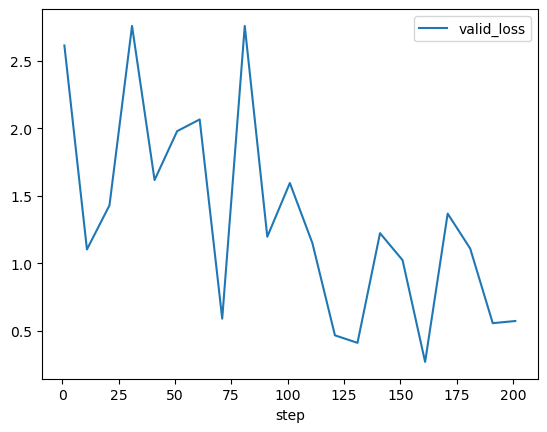

In [50]:
# plot results
df_loss = df.dropna(subset=['valid_loss'])
df_loss.plot(x='step', y='valid_loss', kind='line')

## Use-sase example 2

Build fine-tuned GPT model as code and API assistant for torch hub models (hundreds of API's).

In [51]:
fname_train = "../data/torchhub_finetune_train.json"
fname_val = "../data/torchhub_finetune_val.json"

# Load the train dataset
with open(fname_train, 'r', encoding='utf-8') as f:
    lines = f.readlines()
dataset_train = [json.loads(line) for line in lines]

# Load the train dataset
with open(fname_val, 'r', encoding='utf-8') as f:
    lines = f.readlines()
dataset_val = [json.loads(line) for line in lines]

# Initial dataset stats
print("Num examples:", len(dataset_train))
print("First example:")
for message in dataset_train[0]["messages"]:
    print(message)

Num examples: 506
First example:
{'role': 'system', 'content': 'You are an expert for torch hub APIs'}
{'role': 'user', 'content': 'What API would help me estimate the depth of objects within a single image?'}
{'role': 'assistant', 'content': '{\'api_call\': "torch.hub.load(repo_or_dir=\'intel-isl/MiDaS\', model=\'DPT_Large\', pretrained=True)", \'api_arguments\': {\'repo_or_dir\': \'intel-isl/MiDaS\', \'model\': \'model_type\'}, \'functionality\': \'Computing relative depth from a single image\', \'description\': "\'The MiDaS API can be used to compute relative depth from single images. It provides different models suitable for various use cases, with its largest model, DPT_Large, offering the highest accuracy.\'", \'python_requirements\': \'pip install timm\', \'domain\': \'Classification\'}'}


In [52]:
validate_dataset(dataset_train)

No errors found


In [53]:
validate_dataset(dataset_val)

No errors found


In [54]:
# Uploadfiles

response_train = client.files.create(
  file=open(fname_train, "rb"),
  purpose="fine-tune"
)
train_id = response_train.id
response_val = client.files.create(
  file=open(fname_val, "rb"),
  purpose="fine-tune"
)
val_id = response_val.id

In [57]:
# Cost estimates
def estimate_job(dataset_train, cost_per_token=0.008/1000):
    # Check token limits    
    # Warnings and tokens counts
    n_missing_system = 0
    n_missing_user = 0
    n_messages = []
    convo_lens = []
    assistant_message_lens = []
    encoding = tiktoken.get_encoding("cl100k_base")

    for ex in dataset_train:
        messages = ex["messages"]
        if not any(message["role"] == "system" for message in messages):
            n_missing_system += 1
        if not any(message["role"] == "user" for message in messages):
            n_missing_user += 1
        n_messages.append(len(messages))
        convo_lens.append(num_tokens_from_messages(messages))
        assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
        
    print("Num examples missing system message:", n_missing_system)
    print("Num examples missing user message:", n_missing_user)
    print_distribution(n_messages, "num_messages_per_example")
    print_distribution(convo_lens, "num_total_tokens_per_example")
    print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
    n_too_long = sum(l > 4096 for l in convo_lens)
    print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

    # Pricing and default n_epochs estimate
    MAX_TOKENS_PER_EXAMPLE = 4096

    n_epochs = 3
    n_train_examples = len(dataset_train)

    n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
    print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
    print(f"By default, you'll train for {n_epochs} epochs on this dataset")
    print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
    cost = cost_per_token * n_epochs * n_billing_tokens_in_dataset
    print(f'Estimated cost for training is {round(cost,2)} USD.')

In [58]:
estimate_job(dataset_train)

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 132, 237
mean / median: 175.5395256916996, 174.0
p5 / p95: 153.0, 199.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 90, 186
mean / median: 128.5098814229249, 127.0
p5 / p95: 109.0, 149.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning
Dataset has ~88823 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~266469 tokens
Estimated cost for training is 2.13 USD.


In [59]:
# Create a fine-tuned mode
job = client.fine_tuning.jobs.create(
  training_file=train_id, 
  validation_file=val_id,
  model="gpt-3.5-turbo",
  #hyperparameters={"n_epochs": 4}
)
job_id = job.id
print(job)

FineTuningJob(id='ftjob-fsyhIghKVv7KDejlRtYwRdsX', created_at=1700374142, error=None, fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0613', object='fine_tuning.job', organization_id='org-vy6zLxkP3VBC5Lnu2GMLswhj', result_files=[], status='validating_files', trained_tokens=None, training_file='file-Eu7ckvDxL3Hwhj9t3OTPOsOU', validation_file='file-dhH91HXclXPXn3XAbrlHI44k')


In [63]:
status = client.fine_tuning.jobs.retrieve(job_id)
if status.status == "succeeded":
    print("Model is ready for use!")
    model_id = status.id
    model_runtime = status.finished_at - status.created_at
    model_trained_tokens = status.trained_tokens
    model_hyperparams = status.hyperparameters
    model_name = status.fine_tuned_model
    model_result_files = status.result_files
    print(f"Model name: {model_name}")
    print(f"Model runtime: {model_runtime} seconds")
    print(f"Model trained tokens: {model_trained_tokens}")
    print(f"Model hyperparameters: {model_hyperparams}")
    print(f"Model result files: {model_result_files}")
elif status.status == "running":
    print("Model is not ready yet, try again later")
else:
    print('status:', status.status)

Model is ready for use!
Model name: ft:gpt-3.5-turbo-0613:sydney-informatics-hub::8MWDyqkm
Model runtime: 3635 seconds
Model trained tokens: 263433
Model hyperparameters: Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2)
Model result files: ['file-Z6SctSVVb2jpMOXTK76e0t6Y']


Downloaded result file to step_metrics.csv


<Axes: xlabel='step'>

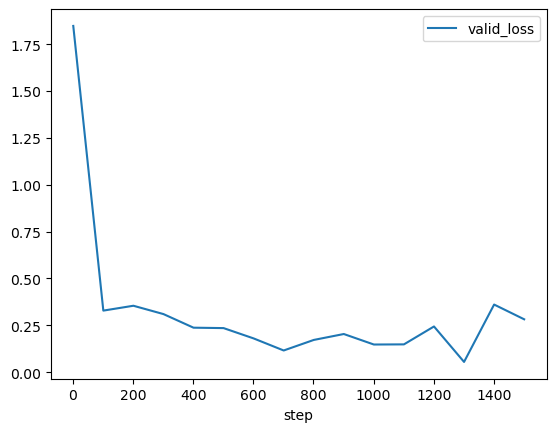

In [64]:
# Validation
#result_file = 'file-Z6SctSVVb2jpMOXTK76e0t6Y'
result_file_content = client.files.retrieve(model_result_files[0])
url = f"https://api.openai.com/v1/files/{result_file_content.id}/content"
r = requests.get(url, headers={"Authorization": f"Bearer {openai.api_key}"})
if r.status_code == 200:
    with open(result_filename, "wb") as f:
        f.write(r.content)
    print(f"Downloaded result file to {result_filename}")
else:
    print('Error downloading result file')

df = pd.read_csv(result_filename)
# show df 
#display(Markdown(df.to_markdown()))

df_loss = df.dropna(subset=['valid_loss'])
df_loss.plot(x='step', y='valid_loss', kind='line')

In [67]:
# Test model
isel = 3
query = dataset_val[isel]['messages'][1]['content']
test_answer = dataset_val[isel]['messages'][2]['content']
display(Markdown('Q: ' + query))
display(Markdown(test_answer))

Q: Design an intelligent robot. Tell me how to build a robot that can estimate objects' distance from its camera just by taking a photo.

{'api_call': "torch.hub.load(repo_or_dir='intel-isl/MiDaS', model='DPT_Hybrid', pretrained=True)", 'api_arguments': {'repo_or_dir': 'intel-isl/MiDaS', 'model': 'model_type'}, 'functionality': 'Computing relative depth from a single image', 'description': "'Use the pretrained MiDaS model to estimate the relative depth of objects from a single image captured by the robot\\'s camera.'", 'python_requirements': 'pip install timm', 'domain': 'Classification'}

In [68]:
# Get model response
#model_name = "ft:gpt-3.5-turbo-0613:sydney-informatics-hub::8MWDyqkm"
query = "Tell me how to estimate objects' distance from its camera just by taking a photo"
system = "You are an expert for torch hub APIs."
result = query_gpt(query, model=model_name, system_str = system, temperature =0, max_tokens=1000)
# print result as markdown
display(Markdown(result))

{'api_call': "torch.hub.load(repo_or_dir='intel-isl/MiDaS', model='DPT_Hybrid', pretrained=True)", 'api_arguments': {'repo_or_dir': 'intel-isl/MiDaS', 'model': 'model_type'}, 'functionality': 'Computing relative depth from a single image', 'description': "'Load the pretrained MiDaS model from PyTorch Hub, which can estimate the relative depth of objects in an image, providing an approximation of their distance from the camera.'", 'python_requirements': 'pip install timm', 'domain': 'Classification'}

### Test generated API call

In [222]:
# Ask GPT-4 to generate a function call
query = f"write code for Jupyter notebook to estimate objects' distance from its camera just by taking a photo.\n\
    Use the API details below for creating code and dependency installation.\n\
    API details: {result}"

model_name = "gpt-4"
system = "You are a Python coding assistant."
result = query_gpt(query, model=model_name, system_str = system, temperature =0, max_tokens=1000)
# print result as markdown
display(Markdown(result))

First, you need to install the necessary dependencies. You can do this by running the following command in your Jupyter notebook:

```python
!pip install timm
```

Then, you can use the following code to load the pretrained MiDaS model from PyTorch Hub and estimate the relative depth from a single image:

```python
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the pretrained MiDaS model from PyTorch Hub
model = torch.hub.load('intel-isl/MiDaS', 'DPT_Large', pretrained=True)

# Ensure the model is in evaluation mode
model.eval()

# Define the image transformation
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def estimate_distance(image_path):
    # Load and transform the image
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)

    # Ensure the image tensor is on the same device as the model
    img = img.to(next(model.parameters()).device)

    # Compute the depth map
    with torch.no_grad():
        depth_map = model(img)

    # Convert the depth map to a numpy array
    depth_map = depth_map.squeeze().cpu().numpy()

    return depth_map
```

You can use the `estimate_distance` function to estimate the relative depth from a single image. The function takes the path to an image file as input and returns a depth map as a numpy array. The depth map can be used to estimate the distance of objects from the camera.

Please note that this code assumes that you have a CUDA-compatible GPU available. If you don't, you can run the model on the CPU by replacing `img = img.to(next(model.parameters()).device)` with `img = img.cpu()`.

In [223]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the pretrained MiDaS model from PyTorch Hub
model = torch.hub.load('intel-isl/MiDaS', 'DPT_Large', pretrained=True)

# Ensure the model is in evaluation mode
model.eval()

# Define the image transformation
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

def estimate_distance(image_path):
    # Load and transform the image
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0)

    # Ensure the image tensor is on the same device as the model
    img = img.to(next(model.parameters()).device)

    # Compute the depth map
    with torch.no_grad():
        depth_map = model(img)

    # Convert the depth map to a numpy array
    depth_map = depth_map.squeeze().cpu().numpy()

    return depth_map

Using cache found in /Users/seb/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /Users/seb/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [01:28<00:00, 15.6MB/s] 


In [225]:
# Test generated code on example image above
url = "https://informatics.sydney.edu.au/images/CodingChallengeImages/innov_award.JPG"
# download image to file
fname_img = 'image.jpg'
r = requests.get(url, allow_redirects=True)
open(fname_img, 'wb').write(r.content)

depth_map = estimate_distance(fname_img)

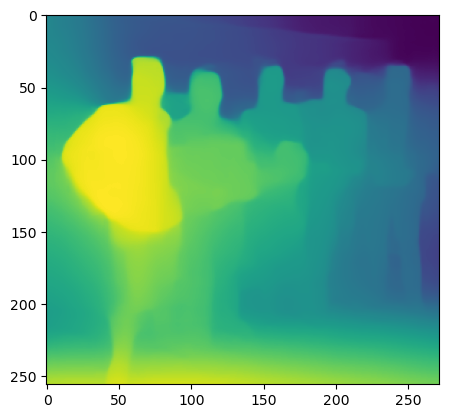

In [229]:
# show depth map
import matplotlib.pyplot as plt
plt.imshow(depth_map)
plt.show()